In [86]:
import numpy as np
import pandas as pd
import gc
import time
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import copy
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import joblib
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
if not os.path.exists('CSV_files'):
    os.mkdir('CSV_files')
if not os.path.exists('models'):
    os.mkdir('models')
    
# set = True if want to Oversampling with SMOTE
is_smote = False

# Prepare data

In [87]:
app_train = pd.read_csv('./dataset/train.csv')
original_test = pd.read_csv('./dataset/test.csv')
app_test = copy.deepcopy(original_test)
print('app_train shape',app_train.shape)
print('app_test shape',app_test.shape)

app_train shape (13293, 156)
app_test shape (4422, 155)


/home/hungphan/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [88]:
app_train.isnull().sum()


index                                                 0
hashed_factory_id                                     0
country                                              67
hashed_type_of_inspection                            68
style_number                                         71
                                                     ..
factory_product_measurement_minor_defect_rate_60      0
factory_product_measurement_minor_defect_rate_90      0
factory_product_measurement_minor_defect_rate_120     0
factory_product_measurement_minor_defect_rate_150     0
label                                                 0
Length: 156, dtype: int64

In [89]:
app_train['label'].value_counts()


0    12641
1      652
Name: label, dtype: int64

In [90]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 156 entries, index to label
dtypes: float64(145), int64(2), object(9)
memory usage: 15.8+ MB


# Preprocessing data
## Remove columns with unique values 

In [91]:
app_train.drop('index',inplace=True,axis=1)
train_unique_columns = []
for col in app_train.columns:
    if len(app_train[col].unique()) == 1:
        train_unique_columns.append(col)
        app_train.drop(col,inplace=True,axis=1)

app_test.drop('index',inplace=True,axis=1)

for col in train_unique_columns:
    app_test.drop(col,inplace=True,axis=1)
print("app_train shape:", app_train.shape)
print("app_test shape:", app_test.shape)


app_train shape: (13293, 115)
app_test shape: (4422, 114)


In [92]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("lected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [93]:
print("app_train missing value")
missing_values = missing_values_table(app_train)
missing_values.head(20)



app_train missing value
lected dataframe has 115 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
style_number,71,0.5
hashed_product_category,69,0.5
hashed_type_of_inspection,68,0.5
country,67,0.5
brand_number,61,0.5
item_number,59,0.4
hashed_product_line,58,0.4


In [94]:
print("app_test missing value")
missing_values = missing_values_table(app_test)
missing_values.head(20)



app_test missing value
lected dataframe has 114 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
hashed_product_line,27,0.6
hashed_type_of_inspection,24,0.5
brand_number,22,0.5
item_number,21,0.5
style_number,19,0.4
country,18,0.4
hashed_product_category,18,0.4


In [95]:
app_train['label'].value_counts()


0    12641
1      652
Name: label, dtype: int64

## Fill NAN values

In [96]:
missing_value_in_columns = missing_values.index.to_list()
for column in missing_value_in_columns:
    app_train[column] = app_train[column].fillna(app_train[column].value_counts().index[0])
    app_test[column] = app_test[column].fillna(app_test[column].value_counts().index[0])


In [97]:
missing_values = missing_values_table(app_train)
missing_values.head(20)
app_train

lected dataframe has 115 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150,label
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.032258,0.028571,0.027778,...,0.004545,0.004545,0.004545,0.004545,0.0,0.0,0.0,0.0,0.0,0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.000000,0.200000,0.035714,0.020408,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000444,0.000400,0.000400,0.000400,0.0,0.0,0.0,0.0,0.0,0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,15,1.0,0.000000,0.000000,0.022222,0.021277,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13289,9213adcfaa233c1bd362eeaaef15269b1f15afe1,Nicaragua,e06d28d1365467625ebfa999328501705a3398bb,1,18,1.0,0.015385,0.009174,0.012195,0.010870,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13290,5a06094857c4e9b5bd124cf37a6e7d336bb8edd4,Cambodia,e06d28d1365467625ebfa999328501705a3398bb,3,20,1.0,0.071429,0.053571,0.045977,0.039604,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
13291,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,9,33,1.0,0.000000,0.000000,0.023529,0.018868,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [98]:
missing_values = missing_values_table(app_test)
missing_values.head(20)
app_test

lected dataframe has 114 columns.
There are 0 columns that have missing values.


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,...,factory_product_packaging_major_defect_rate_30,factory_product_packaging_major_defect_rate_60,factory_product_packaging_major_defect_rate_90,factory_product_packaging_major_defect_rate_120,factory_product_packaging_major_defect_rate_150,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60,factory_product_packaging_minor_defect_rate_90,factory_product_packaging_minor_defect_rate_120,factory_product_packaging_minor_defect_rate_150
0,57e6f82ac38828e1c4cc9a6ff415a5ad2fa94507,China,e06d28d1365467625ebfa999328501705a3398bb,1,20,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,67bc0575f067a61d385539a2169c649814accea7,Nicaragua,4a31b54c7b1ada762e54a711dc598073de477352,1,18,1.0,0.031250,0.032258,0.071429,0.070175,...,0.000333,0.000161,0.000094,0.000085,0.000085,0.0,0.0,0.0,0.0,0.0
2,ab1e388558d6ea7093a4f7912cd1381e2a2962ae,China,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,8e0114f5d7c26b37cec7f58a197a93bbc49e14a6,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,10,1.0,0.007407,0.003937,0.002865,0.002331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,52ef0901f440dc5f007c4f8d79eff436d79da852,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,7,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,b6f1eddfb2a0695fe5d8cd3fdb8f5e5db2d0efc3,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,2,16.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4418,864a334df4c3602dc835dfba496cde1056374bbd,China,e06d28d1365467625ebfa999328501705a3398bb,1,30.0,1.0,0.000000,0.000000,0.000000,0.009009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4419,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,10,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4420,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,30.0,1.0,0.055556,0.031250,0.025641,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [99]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 115 entries, hashed_factory_id to label
dtypes: float64(105), int64(1), object(9)
memory usage: 11.7+ MB


In [100]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
print("training shape", app_train.shape)
print("testing shape", app_test.shape)


training shape (13293, 115)
testing shape (4422, 114)


In [101]:
object_cols = app_train.select_dtypes(include = "object").columns.to_list()
object_cols

['hashed_factory_id',
 'country',
 'hashed_type_of_inspection',
 'style_number',
 'item_number',
 'brand_number',
 'hashed_product_line',
 'hashed_product_category',
 'hashed_product_id']

In [102]:
labels =  app_train['label']
data = app_train.drop('label', axis=1)

## Remove the correlated features

In [103]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
data.drop(to_drop, axis=1, inplace=True)
app_test.drop(to_drop, axis=1, inplace=True)
print("training shape", data.shape)
print("testing shape", app_test.shape)


training shape (13293, 35)
testing shape (4422, 35)


# Transform continuous data


In [104]:
cont_features = []
for col_name in data.columns:
    if col_name == 'label':
        continue
    if app_train[col_name].dtype != 'object':
        cont_features.append(col_name)
print(len(cont_features))


26


In [105]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(data[cont_features])
data[cont_features] = imputer.transform(data[cont_features])
app_test[cont_features] = imputer.transform(app_test[cont_features])
scaler.fit(data[cont_features])
data[cont_features] = scaler.transform(data[cont_features])
app_test[cont_features] = scaler.transform(app_test[cont_features])
print('Training data shape: ', data.shape)
print('Testing data shape: ', app_test.shape)
data

Training data shape:  (13293, 35)
Testing data shape:  (4422, 35)


,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,hashed_product_line,hashed_product_category,...,product_packaging_critical_defect_rate_120,product_packaging_minor_defect_rate_30,product_packaging_minor_defect_rate_60,factory_product_defect_rate_30,factory_product_workmanship_critical_defect_rate_30,factory_product_workmanship_minor_defect_rate_30,factory_product_packaging_defect_rate_30,factory_product_packaging_critical_defect_rate_30,factory_product_packaging_minor_defect_rate_30,factory_product_packaging_minor_defect_rate_60
0,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.032258,a8a2b30f8dba82d690db42ce743475f11be31030,f6b92bb959fed88727f3cc3970a4f9ca9255615b,...,0.0000,0.0,0.0,0.003450,0.0,0.000000,0.004545,0.0,0.0,0.0
1,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.000000,0.200000,a8a2b30f8dba82d690db42ce743475f11be31030,657eb65b25e047e0aa07699b6cc55507272f52f9,...,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,a8a2b30f8dba82d690db42ce743475f11be31030,4a035f0031c805f13a308968231d56cb12009bc1,...,0.0000,0.0,0.0,0.003029,0.0,0.006854,0.000000,0.0,0.0,0.0
3,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.000000,0.000000,a8a2b30f8dba82d690db42ce743475f11be31030,6a812c559943cb2c29da6c739b132c3d4a8905f1,...,0.0062,0.0,0.0,0.001162,0.0,0.000000,0.000000,0.0,0.0,0.0
4,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.000000,0.000000,a8a2b30f8dba82d690db42ce743475f11be31030,4a035f0031c805f13a308968231d56cb12009bc1,...,0.0000,0.0,0.0,0.002872,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,15,1.0,0.000000,0.000000,a8a2b30f8dba82d690db42ce743475f11be31030,5715b207401555d8f282bf63ef46a9cc795140f8,...,0.0000,0.0,0.0,0.003630,0.0,0.000000,0.000000,0.0,0.0,0.0
13289,9213adcfaa233c1bd362eeaaef15269b1f15afe1,Nicaragua,e06d28d1365467625ebfa999328501705a3398bb,1,18,1.0,0.015385,0.009174,a8a2b30f8dba82d690db42ce743475f11be31030,3e320c3e3556eccdfbd52ef5c5ef5e8c87571101,...,0.0000,0.0,0.0,0.003098,0.0,0.000000,0.000000,0.0,0.0,0.0
13290,5a06094857c4e9b5bd124cf37a6e7d336bb8edd4,Cambodia,e06d28d1365467625ebfa999328501705a3398bb,3,20,1.0,0.071429,0.053571,a8a2b30f8dba82d690db42ce743475f11be31030,834519fbea2ede850f6d069a86b76d61eb2edf13,...,0.0000,0.0,0.0,0.004017,0.0,0.000000,0.000000,0.0,0.0,0.0
13291,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,9,33,1.0,0.000000,0.000000,a8a2b30f8dba82d690db42ce743475f11be31030,4a50d9e625a5c238123f407fdb07f2842b241d69,...,0.0000,0.0,0.0,0.002742,0.0,0.006414,0.000000,0.0,0.0,0.0


# Oversampling with SMOTE

In [106]:
if is_smote:
    data,labels=SMOTE().fit_resample(data,labels.values.ravel())


In [107]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=11)


# Training, evaluation, and save to CSV file for CatBoostClassifier

In [108]:
# CatBoostClassifier model
clf = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC']
)

clf.fit(
    X_train, y_train,
    cat_features=object_cols,
    eval_set=(X_val, y_val),
    verbose=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2719706	test: 0.2835426	best: 0.2835426 (0)	total: 10.3ms	remaining: 1.02s
1:	learn: 0.1953657	test: 0.2117261	best: 0.2117261 (1)	total: 19.9ms	remaining: 973ms
2:	learn: 0.1691305	test: 0.1860791	best: 0.1860791 (2)	total: 31ms	remaining: 1s
3:	learn: 0.1611009	test: 0.1807749	best: 0.1807749 (3)	total: 40.6ms	remaining: 976ms
4:	learn: 0.1541892	test: 0.1735475	best: 0.1735475 (4)	total: 50.6ms	remaining: 962ms
5:	learn: 0.1498743	test: 0.1687654	best: 0.1687654 (5)	total: 60ms	remaining: 940ms
6:	learn: 0.1476874	test: 0.1679002	best: 0.1679002 (6)	total: 72.3ms	remaining: 961ms
7:	learn: 0.1470048	test: 0.1679247	best: 0.1679002 (6)	total: 81.1ms	remaining: 932ms
8:	learn: 0.1457118	test: 0.1671843	best: 0.1671843 (8)	total: 91.8ms	remaining: 928ms
9:	learn: 0.1445299	test: 0.1681665	best: 0.1671843 (8)	total: 100ms	remaining: 902ms
10:	learn: 0.1431381	test: 0.1676791	best: 0.1671843 (8)	total: 111ms	remaining: 901ms
11:	learn: 0.1422770	test: 0.1685109	best: 0.167184

98:	learn: 0.0702085	test: 0.2032718	best: 0.1671843 (8)	total: 1.01s	remaining: 10.2ms
99:	learn: 0.0693787	test: 0.2046774	best: 0.1671843 (8)	total: 1.02s	remaining: 0us

bestTest = 0.1671843014
bestIteration = 8

Shrink model to first 9 iterations.


In [109]:
filename = './models/CatBoostClassifier_80_20.sav'
joblib.dump(clf, filename)

['./models/CatBoostClassifier_80_20.sav']

In [110]:
app_test[object_cols] = app_test[object_cols].astype(str)

In [111]:

def report_result_and_save_CSV(X_val, y_val, model, is_save_csv,original_test, app_test, name_csv):
    print('Report result')
    y_pred = model.predict_proba(X_val)[:,1]

    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)

    ix = -1
    max_score = 0
    for idx, score in enumerate(fscore):
        if score > max_score:
            max_score = score
            ix = idx

    print('threshold: ', thresholds[ix], 'Best_fscore:',fscore[ix])
    temp = copy.deepcopy(y_pred)
    temp[temp>=thresholds[ix]] = 1
    temp[temp<thresholds[ix]] = 0
    print(classification_report(y_val, temp))
    print("Precision:\t", metrics.precision_score(y_val, temp))
    print("Recall:\t\t", metrics.recall_score(y_val, temp))
    print("F1:\t\t", metrics.f1_score(y_val, temp))
    print("Accuracy:\t", metrics.accuracy_score(y_val, temp))
    print("Confusion matrix:\n",metrics.confusion_matrix(y_val, temp))
    submit = None
    if is_save_csv:
        test_pred = model.predict_proba(app_test)[:, 1]
        temp = copy.deepcopy(test_pred)
        temp[temp>=thresholds[ix]] = 1
        temp[temp<thresholds[ix]] = 0
        submit = original_test
        submit['TARGET'] = temp
        submit.to_csv('./CSV_files/{}.csv'.format(name_csv), index = False)
    print('----------------------End report ----------------')
    return submit, thresholds[ix]


In [112]:
submit, _ = report_result_and_save_CSV(X_val, y_val, clf, True, original_test, app_test,"summit_catboot_80_20")
submit

Report result
threshold:  0.16755685920112623 Best_fscore: 0.3679525222551929
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2513
           1       0.32      0.42      0.37       146

    accuracy                           0.92      2659
   macro avg       0.65      0.69      0.66      2659
weighted avg       0.93      0.92      0.92      2659

Precision:	 0.32460732984293195
Recall:		 0.4246575342465753
F1:		 0.3679525222551929
Accuracy:	 0.919894697254607
Confusion matrix:
 [[2384  129]
 [  84   62]]


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


----------------------End report ----------------


,index,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,TARGET
0,26,57e6f82ac38828e1c4cc9a6ff415a5ad2fa94507,China,e06d28d1365467625ebfa999328501705a3398bb,1,20,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,67bc0575f067a61d385539a2169c649814accea7,Nicaragua,4a31b54c7b1ada762e54a711dc598073de477352,1,18,1.0,0.031250,0.032258,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,63,ab1e388558d6ea7093a4f7912cd1381e2a2962ae,China,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,64,8e0114f5d7c26b37cec7f58a197a93bbc49e14a6,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,10,1.0,0.007407,0.003937,0.002865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,52ef0901f440dc5f007c4f8d79eff436d79da852,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,7,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20968,b6f1eddfb2a0695fe5d8cd3fdb8f5e5db2d0efc3,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,2,16.0,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4418,20969,864a334df4c3602dc835dfba496cde1056374bbd,China,e06d28d1365467625ebfa999328501705a3398bb,1,30.0,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4419,20971,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,NaN,1.0,0.055556,0.031250,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4420,20972,cd2bf6a940623a271e2e425d95d7689c2db69e9f,China,e06d28d1365467625ebfa999328501705a3398bb,2,30.0,1.0,0.055556,0.031250,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.0    4073
1.0     349
Name: TARGET, dtype: int64

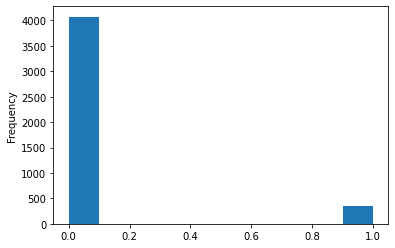

In [113]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()

# Using Kfold for training and evaluation to choose the best model for each fold and compile all k-model by choosing the average result

In [114]:
def make_classification():
    clf = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC'])
    return clf


In [115]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)


In [116]:
list_model = []
list_best_threshold = []
count = 0 
for train_ix, test_ix in kfold.split(data, labels):
    count += 1
    print("--------------------------------------")
    print("FOLD: {}".format(count))
    X_train_, X_val_ =  pd.DataFrame(data.values[train_ix], columns= data.columns.values.tolist()), pd.DataFrame(data.values[test_ix],  columns= data.columns.values.tolist())
    y_train_, y_val_ = labels.values[train_ix], labels.values[test_ix]
    model =None
    model = make_classification()
    model.fit(
        X_train_, y_train_,
        cat_features=object_cols,
        eval_set=(X_val_, y_val_),
        verbose=False,
        plot=False
    )
    filename = './models/CatBoostClassifier_fold_{}.sav'.format(count)
    joblib.dump(model, filename)
    _, threshold = report_result_and_save_CSV(X_val_, y_val_, model, False, '', '','')
    list_model.append(model)
    list_best_threshold.append(threshold)

--------------------------------------
FOLD: 1
Report result
threshold:  0.1763215101121 Best_fscore: 0.3037974683544304
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2529
           1       0.26      0.37      0.30       130

    accuracy                           0.92      2659
   macro avg       0.61      0.66      0.63      2659
weighted avg       0.93      0.92      0.92      2659

Precision:	 0.25806451612903225
Recall:		 0.36923076923076925
F1:		 0.3037974683544304
Accuracy:	 0.9172621286197818
Confusion matrix:
 [[2391  138]
 [  82   48]]
----------------------End report ----------------
--------------------------------------
FOLD: 2


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Report result
threshold:  0.08965553176528362 Best_fscore: 0.28515625
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2528
           1       0.19      0.56      0.29       131

    accuracy                           0.86      2659
   macro avg       0.58      0.72      0.60      2659
weighted avg       0.94      0.86      0.89      2659

Precision:	 0.19160104986876642
Recall:		 0.5572519083969466
F1:		 0.28515625
Accuracy:	 0.8623542685220007
Confusion matrix:
 [[2220  308]
 [  58   73]]
----------------------End report ----------------
--------------------------------------
FOLD: 3


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Report result
threshold:  0.12864603338216116 Best_fscore: 0.289044289044289
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2528
           1       0.21      0.47      0.29       131

    accuracy                           0.89      2659
   macro avg       0.59      0.69      0.61      2659
weighted avg       0.93      0.89      0.91      2659

Precision:	 0.2080536912751678
Recall:		 0.4732824427480916
F1:		 0.289044289044289
Accuracy:	 0.8852952237683339
Confusion matrix:
 [[2292  236]
 [  69   62]]
----------------------End report ----------------
--------------------------------------
FOLD: 4


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Report result
threshold:  0.18450717951415052 Best_fscore: 0.30597014925373134
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2528
           1       0.30      0.32      0.31       130

    accuracy                           0.93      2658
   macro avg       0.63      0.64      0.63      2658
weighted avg       0.93      0.93      0.93      2658

Precision:	 0.2971014492753623
Recall:		 0.3153846153846154
F1:		 0.30597014925373134
Accuracy:	 0.9300225733634312
Confusion matrix:
 [[2431   97]
 [  89   41]]
----------------------End report ----------------
--------------------------------------
FOLD: 5


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Report result
threshold:  0.19238563762979952 Best_fscore: 0.3197026022304833
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2528
           1       0.31      0.33      0.32       130

    accuracy                           0.93      2658
   macro avg       0.64      0.65      0.64      2658
weighted avg       0.93      0.93      0.93      2658

Precision:	 0.30935251798561153
Recall:		 0.33076923076923076
F1:		 0.3197026022304833
Accuracy:	 0.9311512415349887
Confusion matrix:
 [[2432   96]
 [  87   43]]
----------------------End report ----------------


<ipython-input-111-00f45e75f04f>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [117]:
def evaluat_all_data_or_submit(data, labels, list_model, list_best_threshold, is_submit=False, name_csv=None, original_test=None):
    list_result_pre = []
    for idx, model in enumerate(list_model):
        y_pred = model.predict_proba(data)[:,1]
        temp = copy.deepcopy(y_pred)
        temp[temp>=list_best_threshold[idx]] = 1
        temp[temp<list_best_threshold[idx]] = 0
        list_result_pre.append(temp)
        if labels is not None:
            print("Report result model_{}".format(idx+1))
            print(classification_report(labels, temp))
            print("Confusion matrix:\n",metrics.confusion_matrix(labels, temp))
    num_model = len(list_model)
    result_pre = [0] *len(list_result_pre[0])
    for idx in range(len(list_result_pre[0])):
        count_class = 0
        for idx_model in range(num_model):
            count_class += list_result_pre[idx_model][idx]
        if count_class >= (num_model//2 + 1):
            result_pre[idx] = 1
    if labels is not None:
        print("Final report avg kfold")
        print(classification_report(labels, result_pre))
        print("Confusion matrix:\n",metrics.confusion_matrix(labels, result_pre))
        
    submit = None
    if is_submit:
        submit = original_test
        submit['TARGET'] = result_pre
        submit.to_csv('./CSV_files/{}.csv'.format(name_csv), index = False)
        
    return submit


### Just for fun because evaluation at the traning dataset

In [118]:
evaluat_all_data_or_submit(data, labels, list_model, list_best_threshold) 

Report result model_1
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12641
           1       0.35      0.46      0.40       652

    accuracy                           0.93     13293
   macro avg       0.66      0.71      0.68     13293
weighted avg       0.94      0.93      0.94     13293

Confusion matrix:
 [[12075   566]
 [  352   300]]
Report result model_2
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     12641
           1       0.22      0.63      0.32       652

    accuracy                           0.87     13293
   macro avg       0.60      0.76      0.63     13293
weighted avg       0.94      0.87      0.90     13293

Confusion matrix:
 [[11144  1497]
 [  238   414]]
Report result model_3
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     12641
           1       0.25      0.55      0.34       652

    accuracy    

In [119]:
submit = evaluat_all_data_or_submit(app_test, None, list_model, list_best_threshold, is_submit=True, name_csv='Kfold_catboot', original_test=original_test) 

0    4044
1     378
Name: TARGET, dtype: int64

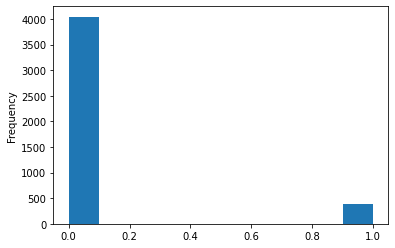

In [120]:
submit['TARGET'].astype(int).plot.hist();
submit['TARGET'].value_counts()